In [1]:
# Import libraries
import scanpy as sc
import lzma
import shutil
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import anndata as an
import scanorama

# Filtering and Merging Data from Zenodo

These code cells decompress .h5ad.xz files and merge .h5ad files getting combined data for the future analysis.

In [ ]:
# Decompressing .h5ad.xz files
def decompress_all_files_in_folder(input_folder):
    file_paths = [
        (
            os.path.join(input_folder, file),
            os.path.join(input_folder, file.replace(".xz", "")),
        )
        for file in os.listdir(input_folder)
        if file.endswith(".h5ad.xz")
    ]

    for input_file, output_file in file_paths:
        try:
            with lzma.open(input_file, "rb") as compressed_file:
                with open(output_file, "wb") as decompressed_file:
                    shutil.copyfileobj(compressed_file, decompressed_file)
            print(f"Файл успешно распакован: {output_file}")
        except Exception as e:
            print(f"Ошибка при распаковке файла {input_file}: {e}")


input_folder = "/home/karitskaya/data/atlas_dataset"

decompress_all_files_in_folder(input_folder)

In [3]:
# Making combined data
directory = "/home/karitskaya/data/filtered_data"
files = [f for f in os.listdir(directory) if f.endswith(".h5ad")]

datasets = {i: file for i, file in enumerate(files)}

adata_list = []
for file in files:
    adata = sc.read(os.path.join(directory, file))
    adata_list.append(adata)

adata_combined = sc.concat(
    adata_list, join="outer", label="dataset", keys=list(datasets.keys())
)
output_path = "/home/karitskaya/karitskaya/own_data/adata_combined.h5ad"
adata_combined.write(output_path)

# Visualiztion our Data before Integration with Scanorama

Run these cells to view the Data before integration with Scanorama.

In [ ]:
output_dir = "/home/karitskaya/karitskaya/pictures"
os.makedirs(output_dir, exist_ok=True)
adata_combined = sc.read_h5ad(
    "/home/karitskaya/karitskaya/own_data/adata_combined.h5ad"
)

# Select highly variable genes
sc.pp.highly_variable_genes(adata_combined, n_top_genes=5000)
adata_combined = adata_combined[:, adata_combined.var.highly_variable]

adata_list = []
for batch in adata_combined.obs["dataset"].unique():
    adata_list.append(adata_combined[adata_combined.obs["dataset"] == batch].copy())

# Doing PCA, leiden clustering and UMAPs
sc.tl.pca(adata_combined, n_comps=50)
sc.pp.neighbors(adata_combined, use_rep="X_pca")
sc.tl.leiden(adata_combined)
sc.tl.umap(adata_combined)

<Figure size 2200x2600 with 0 Axes>

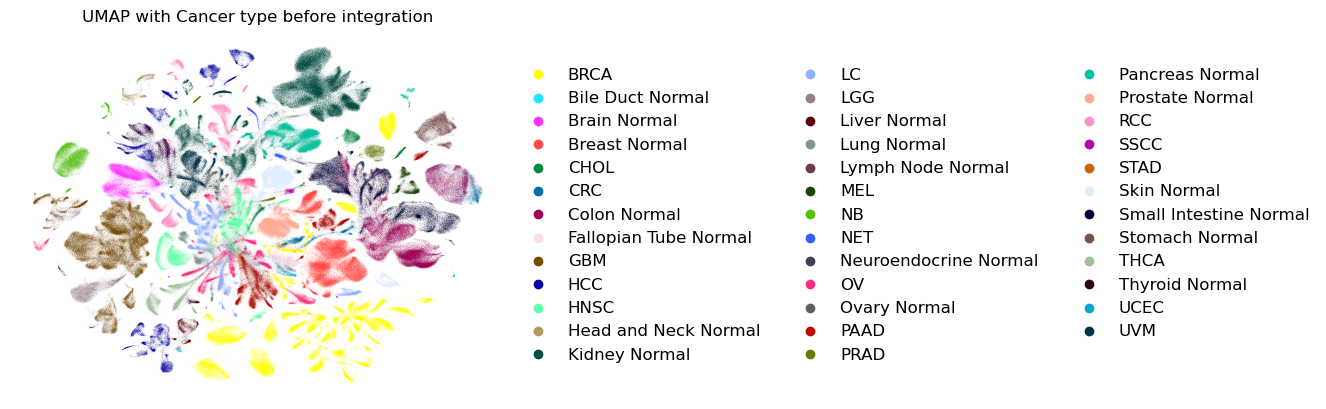

<Figure size 2200x2600 with 0 Axes>

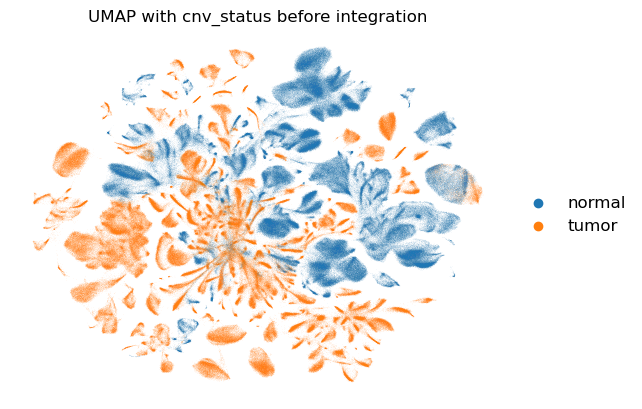

<Figure size 2200x2600 with 0 Axes>

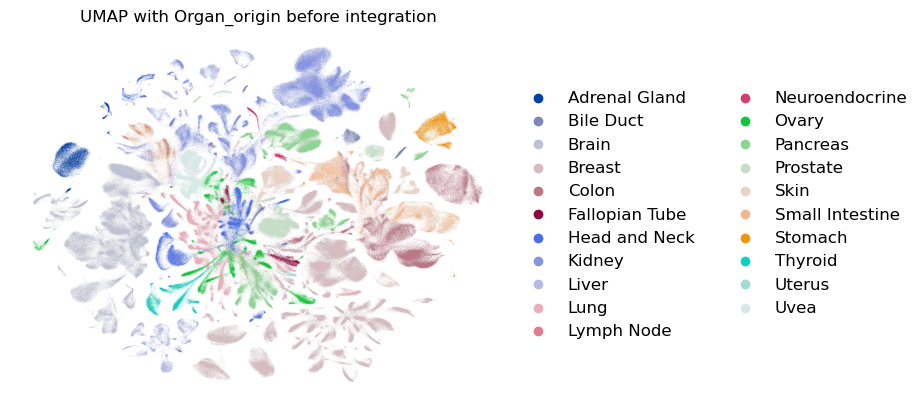

Plot umap_Organ_origin_before_integration done!


In [5]:
# Visualization before integration with Scanorama
for color in ["Cancer type", "cnv_status", "Organ_origin"]:
    plt.figure(figsize=(22, 26))
    sc.pl.umap(
        adata_combined,
        color=color,
        frameon=False,
        legend_fontsize=12,
        title=f"UMAP with {color} before integration",
        show=True,
    )
print(f"Plot umap_{color}_before_integration done!")

# Integration with Scanorama

In [ ]:
# Scanorama integration
gc.collect()
adata_cor = scanorama.correct_scanpy(adata_list, return_dimred=True, batch_size=500)

In [ ]:
# Concat into Anndata object
adata_cortex = sc.concat(
    adata_cor,
    label="dataset",
    keys=[adata.obs["dataset"][0] for adata in adata_cor],
    join="outer",
    uns_merge="unique",
)

sc.pp.neighbors(adata_cortex, use_rep="X_scanorama")
sc.tl.umap(adata_cortex)
sc.tl.leiden(adata_cortex, key_added="clusters", flavor="leidenalg", directed=False)
adata_cortex.write(
    "/home/karitskaya/karitskaya/own_data/adata_scanorama_corrected_5000_hvg.h5ad"
)

# Visualiztion our Data after Integration with Scanorama

Run these cells to view the Data after integration with Scanorama.

<Figure size 2200x2600 with 0 Axes>

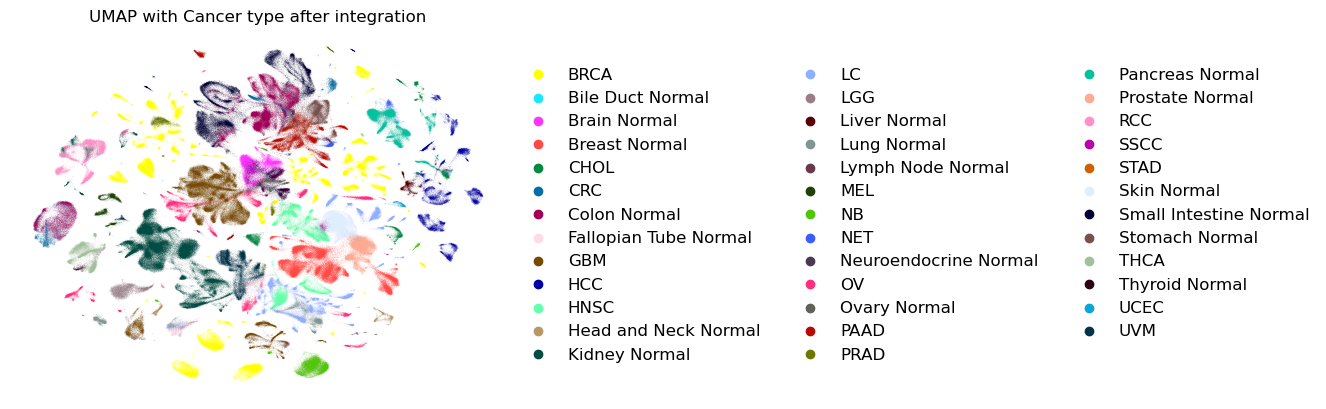

<Figure size 2200x2600 with 0 Axes>

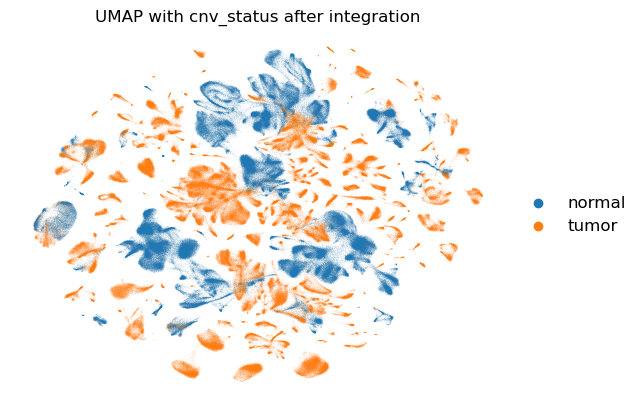

<Figure size 2200x2600 with 0 Axes>

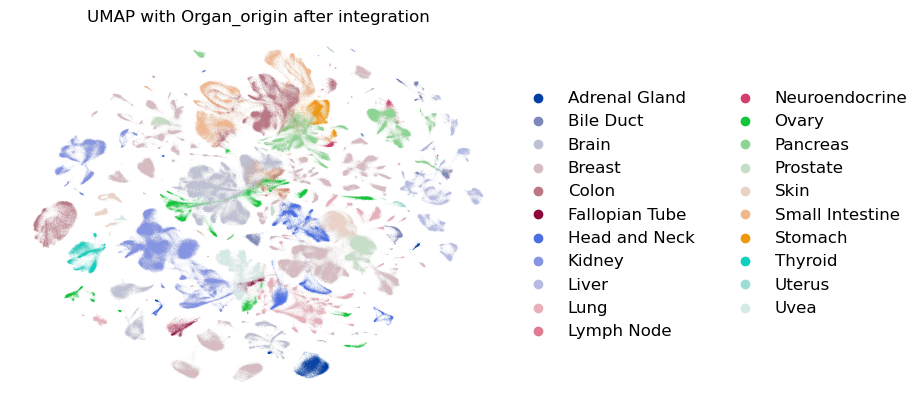

Plot umap_Organ_origin_after_integration done!


In [9]:
# Visualization after integration with Scanorama
for color in ["Cancer type", "cnv_status", "Organ_origin"]:
    plt.figure(figsize=(22, 26))
    sc.pl.umap(
        adata_cortex,
        color=color,
        frameon=False,
        legend_fontsize=12,
        title=f"UMAP with {color} after integration",
        show=True,
    )
print(f"Plot umap_{color}_after_integration done!")